__Remember__: 
 * Everything takes longer than expected
 * Break into separate notebooks when analysis gets long enough

# Setup

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.insert(0, '/home/mritter/code/preposterous')

In [7]:
pwd

'/home/mritter/code/quantifiedself'

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import itertools
import scipy.stats

/home/mritter/.local/share/virtualenvs/preposterous-9I4DbeKd/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [174]:
raw_reporter = pd.read_csv('data/reporter20180729.csv', 
                     parse_dates=['Timestamp of Report (Local Time)']
                    ).rename(columns={'Timestamp of Report (Local Time)':'ts', 'Choose intervention ':'intervention', 'How does your stomach feel?':'outcome'}
                    ).set_index('ts')
raw_reporter['outcome'] = raw_reporter['outcome'].apply(lambda x: x.strip() if pd.notnull(x) else '')
raw_reporter['day'] = pd.to_datetime(raw_reporter.index.date)
reporter = raw_reporter[['day', 'intervention', 'outcome']].copy()
print("Earliest recording: {:%Y.%m.%d}".format(reporter.index.min()))
print("Latest recording: {:%Y.%m.%d}".format(reporter.index.max()))
print("Days recorded: {:0.0f}".format(reporter.index.nunique()))
print("Recordings per day: {:0.1f}".format(reporter.groupby(pd.Grouper(freq='1d')).size().mean()))
reporter.tail()

Earliest recording: 2018.07.04
Latest recording: 2018.07.29
Days recorded: 261
Recordings per day: 10.0


day intervention     outcome
ts                                                     
2018-07-28 22:04:42 2018-07-28          NaN            
2018-07-29 07:59:51 2018-07-29          NaN            
2018-07-29 08:51:12 2018-07-29          NaN  Noticeable
2018-07-29 10:55:37 2018-07-29          NaN  Noticeable
2018-07-29 12:48:13 2018-07-29          NaN  Noticeable

In [33]:
# Missing values are probably sleep/wake, 
#though look deeper if there are too many
outcomes = reporter.outcome.value_counts()
outcomes = pd.concat([outcomes, outcomes.div(outcomes.sum())], axis=1).round(2)
outcomes

outcome  outcome
Noticeable        148     0.57
                   52     0.20
Totally fine       36     0.14
Distracting        25     0.10

In [175]:
# Look for unexpected numbers
# Nexium bottle had 14 doses - I might have dropped one on the floor, so that means I missed either 1 or 2 reporter entries

interventions = reporter.intervention.value_counts()
interventions = pd.concat([interventions, interventions.div(interventions.sum())], axis=1).round(2)
interventions

intervention  intervention
Tummy Drop (1ct)                               15          0.18
GinGin2x                                       13          0.15
Nex                                            12          0.14
Ginger tea                                     12          0.14
Tums1x                                          9          0.11
Tummy Drop (2ct)                                7          0.08
Motion sickness medication                      5          0.06
Tums2x                                          3          0.04
Milk 1c                                         3          0.04
Exercise                                        3          0.04
Tums1x,Nex                                      1          0.01
GinGin2x,Nex                                    1          0.01
Motion sickness medication,Exercise             1          0.01

In [197]:
mask = reporter.intervention.fillna('').str.contains(',')
l = []
for ix, row in reporter[mask].iterrows():
    for intervention in row.intervention.split(','):
        l.append(pd.Series(
            {'day': row.day,
             'intervention': intervention,
             'outcome': row.outcome,
            },
            name = ix
        ))
reporter = reporter[~mask].append(l)
reporter

day                intervention       outcome
2018-07-04 16:22:00 2018-07-04                         NaN   Distracting
2018-07-04 16:22:39 2018-07-04                         NaN              
2018-07-04 16:23:14 2018-07-04                         NaN              
2018-07-04 16:23:35 2018-07-04                         NaN   Distracting
2018-07-04 16:33:38 2018-07-04                         NaN   Distracting
2018-07-04 16:43:20 2018-07-04            Tummy Drop (1ct)    Noticeable
2018-07-04 17:26:52 2018-07-04                         NaN   Distracting
2018-07-04 18:18:02 2018-07-04                         NaN    Noticeable
2018-07-04 18:43:48 2018-07-04            Tummy Drop (1ct)   Distracting
2018-07-04 20:44:01 2018-07-04            Tummy Drop (1ct)    Noticeable
2018-07-04 21:28:42 2018-07-04                         NaN              
2018-07-05 07:00:23 2018-07-05                         NaN              
2018-07-05 07:45:41 2018-07-05                         NaN    Noticeable
2018-07-05 09:37:49 2018-07-05                         NaN    Noticeable
2018-07-05 14:51:56 2018-07-05                         NaN  Totally fine
2018-07-05 18:48:57 2018-07-05                         NaN  Totally fine
2018-07-05 21:25:00 2018-07-05                         NaN              
2018-07-06 06:53:30 2018-07-06                         NaN              
2018-07-06 06:53:43 2018-07-06                         NaN  Totally fine
2018-07-06 07:06:44 2018-07-06                         NaN              
2018-07-06 09:45:33 2018-07-06                     Milk 1c  Totally fine
2018-07-06 10:37:06 2018-07-06                         NaN    Noticeable
2018-07-06 13:00:41 2018-07-06                         NaN    Noticeable
2018-07-06 13:35:58 2018-07-06                         NaN  Totally fine
2018-07-06 14:51:08 2018-07-06                         NaN    Noticeable
2018-07-06 17:08:00 2018-07-06                     Milk 1c  Totally fine
2018-07-06 17:43:42 2018-07-06                         NaN  Totally fine
2018-07-06 19:43:44 2018-07-06            Tummy Drop (1ct)  Totally fine
2018-07-06 20:34:57 2018-07-06                  Ginger tea  Totally fine
2018-07-06 21:12:37 2018-07-06                         NaN              
...                        ...                         ...           ...
2018-07-26 11:54:10 2018-07-26                      Tums1x    Noticeable
2018-07-26 13:34:51 2018-07-26                         NaN    Noticeable
2018-07-26 15:39:31 2018-07-26                         NaN  Totally fine
2018-07-26 18:57:17 2018-07-26                         NaN  Totally fine
2018-07-26 22:15:49 2018-07-26                         NaN              
2018-07-27 04:58:05 2018-07-27                         NaN              
2018-07-27 04:58:11 2018-07-27                         NaN    Noticeable
2018-07-27 07:30:17 2018-07-27                         NaN    Noticeable
2018-07-27 08:57:19 2018-07-27                         NaN  Totally fine
2018-07-27 10:56:10 2018-07-27  Motion sickness medication    Noticeable
2018-07-27 16:22:00 2018-07-27            Tummy Drop (1ct)    Noticeable
2018-07-27 17:47:25 2018-07-27                         NaN    Noticeable
2018-07-27 22:29:14 2018-07-27                         NaN              
2018-07-28 07:09:57 2018-07-28                         NaN              
2018-07-28 08:55:24 2018-07-28                         NaN    Noticeable
2018-07-28 10:30:41 2018-07-28                         NaN    Noticeable
2018-07-28 13:35:36 2018-07-28                         NaN    Noticeable
2018-07-28 19:29:06 2018-07-28                         NaN    Noticeable
2018-07-28 20:43:45 2018-07-28                  Ginger tea    Noticeable
2018-07-28 22:04:42 2018-07-28                         NaN              
2018-07-29 07:59:51 2018-07-29                         NaN              
2018-07-29 08:51:12 2018-07-29                         NaN    Noticeable
2018-07-29 10:55:37 2018-07-29                         NaN    Noticeable
2018-07-29 1

In [35]:
raw_mfp = pd.read_csv('data/Nutrition-Summary-2017-04-25-to-2018-07-29.csv')
raw_mfp.columns = raw_mfp.columns.str.lower().str.replace(' \(g\)', '').str.replace(' \(mg\)', '').str.replace(' ', '_')
raw_mfp['ts'] = raw_mfp.apply(lambda x: str(x['date']), axis=1) # + ' ' + str(x['time']), axis=1)
raw_mfp['ts'] = pd.to_datetime(raw_mfp['ts'], errors='coerce')
mfp = raw_mfp.set_index(['ts']).loc['2018-07-01':, ['calories', 'fat', 'saturated_fat']]
print("Earliest recording: {:%Y.%m.%d}".format(mfp.index.min()))
print("Latest recording: {:%Y.%m.%d}".format(mfp.index.max()))
print("Days recorded: {:0.0f}".format(mfp.index.nunique()))
print("Recordings per day: {:0.1f}".format(mfp.groupby(pd.Grouper(freq='1d')).size().mean()))
mfp.tail()

Earliest recording: 2018.07.05
Latest recording: 2018.07.29
Days recorded: 25
Recordings per day: 4.2


calories   fat  saturated_fat
ts                                       
2018-07-28     653.1  12.8            4.2
2018-07-28     488.0   8.2            1.3
2018-07-28     195.3   0.0            0.0
2018-07-29     275.0   8.0            3.0
2018-07-29     542.4   8.8            0.6

In [36]:
raw_mfp.head().T

0                    1  \
date                          2017-04-26           2017-04-26   
meal                           Breakfast                Lunch   
time                                 NaN                  NaN   
calories                             110                381.5   
fat                                    0                  7.3   
saturated_fat                          0                    0   
polyunsaturated_fat                    0                  0.1   
monounsaturated_fat                    0                    0   
trans_fat                              0                    0   
cholesterol                            0                   25   
sodium                                 0               1073.1   
potassium                              0                470.9   
carbohydrates                          3                 58.1   
fiber                                  0                  6.8   
sugar                                  2                 12.9   
protein                                0                 21.4   
vitamin_a                              0                   17   
vitamin_c                              0                 43.4   
calcium                                0                  5.4   
iron                                   0                 20.5   
note                                 NaN                  NaN   
ts                   2017-04-26 00:00:00  2017-04-26 00:00:00   

                                       2                    3  \
date                          2017-04-26           2017-04-26   
meal                              Dinner               Snacks   
time                                 NaN                  NaN   
calories                             617                 89.8   
fat                                 25.4                  0.3   
saturated_fat                       10.6                  0.1   
polyunsaturated_fat                  0.5                  0.1   
monounsaturated_fat                  2.5                    0   
trans_fat                              0                    0   
cholesterol                          103                    0   
sodium                               906                    1   
potassium                            330                361.2   
carbohydrates                       56.3                   23   
fiber                                  4                  2.6   
sugar                                 15                 12.3   
protein                             33.4                  1.1   
vitamin_a                             35                  1.3   
vitamin_c                              6                 14.6   
calcium                                4                  0.5   
iron                                  21                  1.5   
note                                 NaN                  NaN   
ts                   2017-04-26 00:00:00  2017-04-26 00:00:00   

                                       4  
date                          2017-04-27  
meal                           Breakfast  
time                                 NaN  
calories                             110  
fat                                    0  
saturated_fat                          0  
polyunsaturated_fat                    0  
monounsaturated_fat                    0  
trans_fat                              0  
cholesterol                            0  
sodium                                 0  
potassium                              0  
carbohydrates                          3  
fiber                                  0  
sugar                                  2  
protein                                0  
vitamin_a                              0  
vitamin_c                              0  
calcium                                0  
iron                                   0  
note                                 NaN  
ts                   2017-04-27 00:00:00

In [37]:
assert not any(mfp.index.isna())

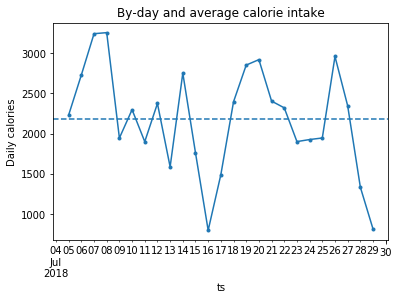

In [206]:
ax = mfp.groupby(pd.Grouper(level=0, freq='1d')).calories.sum().plot(marker='.')
ax.axhline(mfp.groupby(pd.Grouper(level=0, freq='1d')).calories.sum().mean(), linestyle='--')
ax.set_ylabel('Daily calories')
ax.set_title("By-day and average calorie intake")
ax.get_figure().savefig('results/{}_{:%Y%m%d}.png'.format('calories', pd.datetime.today()))


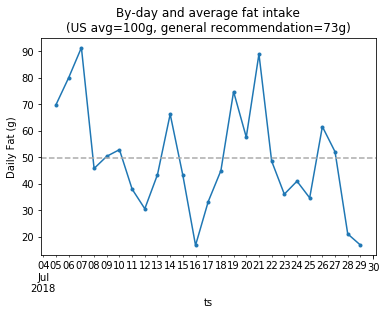

In [207]:
.0000# Sources: 
#  Recommendation: https://health.gov/dietaryguidelines/dga2000/document/choose.htm
#  American actuals: https://www.ars.usda.gov/ARSUserFiles/80400530/pdf/1314/Table_1_NIN_GEN_13.pdf

ax = mfp.groupby(pd.Grouper(level=0, freq='1d')).fat.sum().plot(marker='.')
ax.axhline(mfp.groupby(pd.Grouper(level=0, freq='1d')).fat.sum().mean(), c='#AAAAAA', linestyle='--')
ax.set_ylabel('Daily Fat (g)')
ax.set_title("By-day and average fat intake\n(US avg=100g, general recommendation=73g)")
ax.get_figure().savefig('results/{}_{:%Y%m%d}.png'.format('fat', pd.datetime.today()))

In [49]:
print(reporter.index.size)
print(mfp.index.size)
df = reporter.merge(mfp.groupby(level=0).sum(), 
                    left_on='day', 
                    right_index=True).sort_index()
print("Earliest recording: {:%Y.%m.%d}".format(df.index.min()))
print("Latest recording: {:%Y.%m.%d}".format(df.index.max()))
print("Days recorded: {:0.0f}".format(df.index.nunique()))
print("Recordings per day: {:0.1f}".format(df.groupby(pd.Grouper(freq='1d')).size().mean()))
df.tail()

261
106
Earliest recording: 2018.07.05
Latest recording: 2018.07.29
Days recorded: 250
Recordings per day: 10.0


day intervention     outcome  calories   fat  \
ts                                                                        
2018-07-28 22:04:42 2018-07-28          NaN                1336.4  21.0   
2018-07-29 07:59:51 2018-07-29          NaN                 817.4  16.8   
2018-07-29 08:51:12 2018-07-29          NaN  Noticeable     817.4  16.8   
2018-07-29 10:55:37 2018-07-29          NaN  Noticeable     817.4  16.8   
2018-07-29 12:48:13 2018-07-29          NaN  Noticeable     817.4  16.8   

                     saturated_fat  
ts                                  
2018-07-28 22:04:42            5.5  
2018-07-29 07:59:51            3.6  
2018-07-29 08:51:12            3.6  
2018-07-29 10:55:37            3.6  
2018-07-29 12:48:13            3.6

# Analysis Template

## Point interventions
Some interventions should have an impact fairly quickly. By default, this looks at 2 hours before and after the intervention, which is repeated many times across different days

### Frequentist

In [99]:
def prepost_generator(intervention, window=2):
    """Return df formatted for easy pre/post analysis"""
    outcome_list = [x for x in reporter.outcome.unique().tolist() if len(x)]
    prepost_intervention = pd.DataFrame(columns=pd.MultiIndex.from_product([['pre', 'post'], outcome_list]))
    for ix in reporter[reporter.intervention == intervention].index:
        for arm, outcome in prepost_intervention.columns:
            if arm == 'pre':
                prepost_intervention.loc[ix, (arm, outcome)] = reporter[  (1==1)
                                                  & (reporter.index > ix - pd.Timedelta(window, 'h'))
                                                  & (reporter.index <= ix)
                                                  & (reporter.outcome == outcome)
                                                 ].index.size
            elif arm == 'post':
                prepost_intervention.loc[ix, (arm, outcome)] = reporter[  (1==1)
                                                  & (reporter.index > ix)
                                                  & (reporter.index <= ix + pd.Timedelta(window, 'h'))
                                                  & (reporter.outcome == outcome)
                                                 ].index.size
            else:
                raise ValueError('arm should only be pre or post')

    return prepost_intervention

prepost_intervention = prepost_generator('Tummy Drop (1ct)', window=2)
prepost_intervention.tail()

pre                                post  \
                    Distracting Noticeable Totally fine Distracting   
2018-07-10 14:51:42         0.0        2.0          0.0         0.0   
2018-07-11 10:24:23         0.0        2.0          0.0         0.0   
2018-07-11 12:42:05         0.0        1.0          0.0         0.0   
2018-07-13 13:18:36         0.0        3.0          0.0         0.0   
2018-07-27 16:22:00         0.0        1.0          0.0         0.0   

                                             
                    Noticeable Totally fine  
2018-07-10 14:51:42        0.0          0.0  
2018-07-11 10:24:23        0.0          0.0  
2018-07-11 12:42:05        0.0          1.0  
2018-07-13 13:18:36        0.0          0.0  
2018-07-27 16:22:00        1.0          0.0

In [191]:
def generate_confusion_matrix(prepost_intervention, target='Totally fine'):
    mask = prepost_intervention.sum(axis=1, level=0).applymap(lambda x: x>0).all(axis=1)
    valid_prepost = prepost_intervention.loc[mask, :]
    confusion_matrix = prepost_intervention.sum(axis=0).unstack().loc[:, ['Noticeable', target]]
    oddsratio, pvalue = scipy.stats.fisher_exact(confusion_matrix.values)
    print('sample size: {:0.0f}'.format(mask.sum()))
    print('p-value of no effect: {:0.2f}'.format(pvalue))
    
    confusion_matrix['ratio'] = confusion_matrix.iloc[:, 1].div(confusion_matrix.sum(axis=1))
    return confusion_matrix

confusion_matrix = generate_confusion_matrix(prepost_intervention, 'Totally fine')
confusion_matrix

sample size: 5
p-value of no effect: 1.00


Noticeable  Totally fine     ratio
post        16.0           2.0  0.111111
pre         16.0           1.0  0.058824

In [192]:
def bayesian_prepost(prepost_intervention, target='Totally fine'):
    alpha_prior = 1
    beta_prior = 1

    mask = prepost_intervention.sum(axis=1, level=0).applymap(lambda x: x>0).all(axis=1)
    valid_prepost = prepost_intervention.loc[mask, :]
    confusion_matrix = prepost_intervention.sum(axis=0).unstack().loc[:, ['Noticeable', target]]
    
    # PUT RESULTS HERE
    target_pre = confusion_matrix.loc['pre', target]
    noticeable_pre = confusion_matrix.loc['pre', 'Noticeable']
    target_post = confusion_matrix.loc['post', target]
    noticeable_post = confusion_matrix.loc['post', 'Noticeable']

    posterior_pre = scipy.stats.beta(alpha_prior + distractingcnt_pre,
                                     beta_prior + noticeable_pre)

    posterior_post = scipy.stats.beta(alpha_prior + distractingcnt_post,
                                      beta_prior + noticeable_post)

    simulations = 20000 # We want this to be large to get a better approximation.
    simulations_posterior_pre = posterior_pre.rvs(simulations)
    simulations_posterior_post = posterior_post.rvs(simulations)

    prob = (simulations_posterior_post < simulations_posterior_pre).mean()

    print("Bayesian probability that '{}' in post is less than pre: {:0.2f}".format(target, prob))
    
bayesian_prepost(prepost_intervention)

Bayesian probability that 'Totally fine' in post is less than pre: 0.50


In [195]:
def bayesian_half(prepost_intervention, target='Totally fine'):
    temp = pd.DataFrame(index=np.arange(0, 1, .1), columns=['intervention']) #interventions[interventions>10].index)
    for intervention in temp.columns:
        for p in temp.index:
            temp.loc[p, intervention] = scipy.stats.binom_test(
                x=confusion_matrix.loc['post', target], 
                n=confusion_matrix.loc['post', :].sum(), 
                p=p)
        print("Probability that {} effective half the time: {:0.6f}".format(
            intervention,
            temp.loc[temp.index > .5, 'intervention'].sum()))
        
bayesian_half(prepost_intervention)

Probability that intervention effective half the time: 0.000026


In [196]:
prepost_intervention = prepost_generator('GinGin2x', window=10)
confusion_matrix = generate_confusion_matrix(prepost_intervention, 'Totally fine')
bayesian_prepost(prepost_intervention)
bayesian_half(prepost_intervention)
confusion_matrix

sample size: 13
p-value of no effect: 0.51
Bayesian probability that 'Totally fine' in post is less than pre: 0.63
Probability that intervention effective half the time: 0.000000


Noticeable  Totally fine     ratio
post        49.0           7.0  0.125000
pre         42.0           3.0  0.066667

In [197]:
# Note that there's a real likelihood of "revision to mean bias", because I mostly take Tums when I feel particularly bad
prepost_intervention = prepost_generator('Tums1x', window=10)
confusion_matrix = generate_confusion_matrix(prepost_intervention, 'Totally fine')
bayesian_prepost(prepost_intervention)
bayesian_half(prepost_intervention)
confusion_matrix

sample size: 7
p-value of no effect: 0.13
Bayesian probability that 'Totally fine' in post is less than pre: 0.10
Probability that intervention effective half the time: 0.000000


Noticeable  Totally fine     ratio
post        24.0           3.0  0.111111
pre         46.0           1.0  0.021277

In [198]:
prepost_intervention = prepost_generator('Tummy Drop (2ct)', window=10)
confusion_matrix = generate_confusion_matrix(prepost_intervention, 'Totally fine')
bayesian_prepost(prepost_intervention)
bayesian_half(prepost_intervention)
confusion_matrix

sample size: 6
p-value of no effect: 0.61
Bayesian probability that 'Totally fine' in post is less than pre: 0.57
Probability that intervention effective half the time: 0.000001


Noticeable  Totally fine     ratio
post        22.0           3.0  0.120000
pre         20.0           1.0  0.047619

In [199]:
"""What if I had 6x as much data?"""
prepost_intervention = prepost_generator('Tummy Drop (2ct)', window=10)
temp = pd.concat([prepost_intervention]*6)
confusion_matrix = generate_confusion_matrix(temp, 'Totally fine')
bayesian_prepost(temp)
bayesian_half(prepost_intervention)
print("WARNING: This is hypothetical data")
confusion_matrix

sample size: 36
p-value of no effect: 0.05
Bayesian probability that 'Totally fine' in post is less than pre: 0.59
Probability that intervention effective half the time: 0.000000


Noticeable  Totally fine     ratio
post       132.0          18.0  0.120000
pre        120.0           6.0  0.047619

In [200]:
prepost_intervention = prepost_generator('Motion sickness medication', window=10)
confusion_matrix = generate_confusion_matrix(prepost_intervention, 'Totally fine')
bayesian_prepost(prepost_intervention)
bayesian_half(prepost_intervention)
confusion_matrix

sample size: 5
p-value of no effect: 1.00
Bayesian probability that 'Totally fine' in post is less than pre: 0.50
Probability that intervention effective half the time: 0.000026


Noticeable  Totally fine     ratio
post        16.0           2.0  0.111111
pre         16.0           1.0  0.058824

## Period Interventions
Some things wouldn't be expected to take effect within a few hours, so their impact is better represented by a graph which highlights outcomes over the period of the intervention

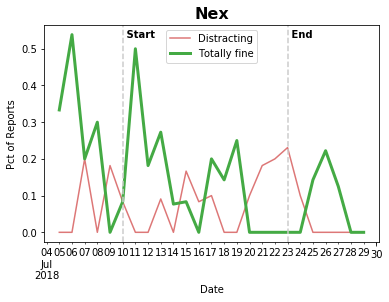

In [94]:
intervention = 'Nex'
def plot_prepost(intervention):
    min_day = df[df.intervention == intervention].index.min()
    max_day = df[df.intervention == intervention].index.max()
    s = pd.get_dummies(df['outcome'])[['Distracting', 'Totally fine']].groupby(pd.Grouper(freq='1d')).mean()
    ax = s['Distracting'].plot(c='#DD7777')
    ax = s['Totally fine'].plot(linewidth=3, c='#44AA44')
    ax.axvline(min_day, c='#CCCCCC', linestyle='--')
    ax.text(min_day, .53, ' Start', fontdict={'weight':'bold'})
    ax.axvline(max_day, c='#CCCCCC', linestyle='--')
    ax.text(max_day, .53, ' End', fontdict={'weight':'bold'})
    ax.set_xlabel('Date')
    ax.set_ylabel('Pct of Reports')
    ax.set_title(intervention, fontdict={'weight':'bold', 'fontsize':16})
    ax.legend()
    ax.get_figure().savefig('results/{}_{:%Y%m%d}.png'.format(intervention.replace(' ', '_'), pd.datetime.today()))
    return ax

_ = plot_prepost('Nex')

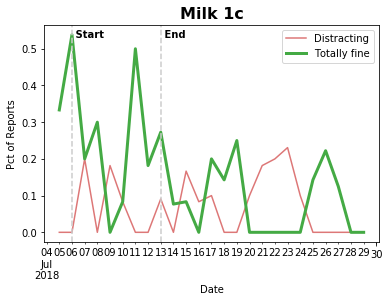

In [95]:
_ = plot_prepost('Milk 1c')


# Test library

In [201]:
! echo $PATH

/home/mritter/.local/share/virtualenvs/preposterous-9I4DbeKd/bin:/home/mritter/.local/share/virtualenvs/preposterous-9I4DbeKd/bin:/usr/local/cuda-9.0/bin:/usr/lib/nvidia-384/bin:/usr/local/cuda-9.0/bin:/usr/lib/nvidia-384/bin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/usr/games:/usr/local/games:/snap/bin


In [202]:
sys.path

['/home/mritter/code/preposterous',
 '',
 '/home/mritter/.local/share/virtualenvs/preposterous-9I4DbeKd/lib/python36.zip',
 '/home/mritter/.local/share/virtualenvs/preposterous-9I4DbeKd/lib/python3.6',
 '/home/mritter/.local/share/virtualenvs/preposterous-9I4DbeKd/lib/python3.6/lib-dynload',
 '/usr/lib/python3.6',
 '/home/mritter/.local/share/virtualenvs/preposterous-9I4DbeKd/lib/python3.6/site-packages',
 '/home/mritter/code/quantifiedself/preposterous',
 '/home/mritter/.local/share/virtualenvs/preposterous-9I4DbeKd/lib/python3.6/site-packages/IPython/extensions',
 '/home/mritter/.ipython']

In [4]:
import preposterous.preposterous as ppl
import importlib
importlib.reload(ppl)
pdf = ppl.PrePostDF()
pdf.add_outcome(filename='data/reporter20180729')
pdf.add_intervention(filename='data/reporter20180729')
pdf.basic_info()
pdf.generate_confusion_matrix(intervention='Tums1x')

/home/mritter/.local/share/virtualenvs/preposterous-9I4DbeKd/lib/python3.6/site-packages/pandas/core/indexing.py:1472: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


Earliest recording: 2018.07.04
Latest recording: 2018.07.29
Recordings per day: 20.3

Outcomes with n>5:
                n   pct
Noticeable    149  0.56
               52  0.20
Totally fine   36  0.14
Distracting    27  0.10

Interventions with n>5:
                             n   pct
Tummy Drop (1ct)            15  0.17
Nex                         14  0.16
GinGin2x                    14  0.16
Ginger tea                  12  0.14
Tums1x                      10  0.11
Tummy Drop (2ct)             7  0.08
Motion sickness medication   6  0.07

Long dataframe tail:
                    intervention outcome
2018-07-07 13:49:51     Exercise     NaN
2018-07-15 11:01:27       Tums1x     NaN
2018-07-15 11:01:27          Nex     NaN
2018-07-17 10:36:46     GinGin2x     NaN
2018-07-17 10:36:46          Nex     NaN
sample size: 6
p-value of no effect: 1.00


Noticeable  Totally fine  ratio
post         7.0           0.0    0.0
pre         12.0           0.0    0.0

In [6]:
import preposterous as temp
temp.__version__

'0.0.1'

In [248]:
pdf.confusion_matrix.reindex(['a', 'b'])

positive  negative  other_intervention  no_outcomes  multiple_outcomes
a       NaN       NaN                 NaN          NaN                NaN
b       NaN       NaN                 NaN          NaN                NaN

In [273]:
pdf.confusion_matrix.astype('int')

positive  negative  other_intervention  \
Tummy Drop (1ct)                   1         6                   1   
GinGin2x                           1         9                   0   
Nex                                1         7                   1   
Ginger tea                         3         1                   1   
Tums1x                             0         5                   1   
Tummy Drop (2ct)                   0         4                   0   
Motion sickness medication         0         2                   0   

                            no_outcomes  multiple_outcomes  
Tummy Drop (1ct)                      6                  1  
GinGin2x                              3                  1  
Nex                                   5                  0  
Ginger tea                            7                  0  
Tums1x                                4                  0  
Tummy Drop (2ct)                      3                  0  
Motion sickness medication            4                  0

In [249]:
interventions = None # pdf.df.intervention.value_counts()[lambda x: x>5].index
pdf.outcomes(positive_outcomes=['Totally fine'], negative_outcomes=['Noticeable', 'Distracting'], interventions=interventions)
pdf.confusion_matrix

positive  negative  other_intervention  \
Tummy Drop (1ct)                 1.0       6.0                 1.0   
GinGin2x                         1.0       9.0                 0.0   
Nex                              1.0       7.0                 1.0   
Ginger tea                       3.0       1.0                 1.0   
Tums1x                           0.0       5.0                 1.0   
Tummy Drop (2ct)                 0.0       4.0                 0.0   
Motion sickness medication       0.0       2.0                 0.0   

                            no_outcomes  multiple_outcomes  
Tummy Drop (1ct)                    6.0                1.0  
GinGin2x                            3.0                1.0  
Nex                                 5.0                0.0  
Ginger tea                          7.0                0.0  
Tums1x                              4.0                0.0  
Tummy Drop (2ct)                    3.0                0.0  
Motion sickness medication          4.0                0.0

In [250]:
pdf.calculate_relative_effectiveness()
pdf.relative_effectiveness

prob                                              \
intervention GinGin2x Ginger tea Motion sickness medication   Nex   
delta                                                               
-0.9             0.00       0.00                       0.00  0.00   
-0.8             0.00       0.00                       0.00  0.00   
-0.7             0.00       0.00                       0.00  0.00   
-0.6             0.00       0.00                       0.00  0.00   
-0.5             0.00       0.00                       0.00  0.00   
-0.4             0.00       0.00                       0.00  0.00   
-0.3             0.00       0.00                       0.01  0.00   
-0.2             0.07       0.00                       0.14  0.02   
-0.1             0.37       0.00                       0.19  0.21   
 0.0             0.33       0.00                       0.19  0.37   
 0.1             0.16       0.01                       0.18  0.25   
 0.2             0.05       0.02                       0.12  0.10   
 0.3             0.01       0.08                       0.09  0.04   
 0.4             0.00       0.15                       0.05  0.01   
 0.5             0.00       0.23                       0.02  0.00   
 0.6             0.00       0.23                       0.01  0.00   
 0.7             0.00       0.21                       0.00  0.00   
 0.8             0.00       0.07                       0.00  0.00   
 0.9             0.00       0.00                       0.00  0.00   

                                                       
intervention Tummy Drop (1ct) Tummy Drop (2ct) Tums1x  
delta                                                  
-0.9                     0.00             0.00   0.00  
-0.8                     0.00             0.00   0.00  
-0.7                     0.00             0.00   0.00  
-0.6                     0.00             0.00   0.00  
-0.5                     0.00             0.00   0.00  
-0.4                     0.00             0.00   0.00  
-0.3                     0.00             0.03   0.04  
-0.2                     0.02             0.23   0.27  
-0.1                     0.15             0.27   0.30  
 0.0                     0.31             0.26   0.19  
 0.1                     0.29             0.11   0.11  
 0.2                     0.15             0.05   0.06  
 0.3                     0.06             0.03   0.02  
 0.4                     0.02             0.01   0.01  
 0.5                     0.00             0.00   0.00  
 0.6                     0.00             0.00   0.00  
 0.7                     0.00             0.00   0.00  
 0.8                     0.00             0.00   0.00  
 0.9                     0.00             0.00   0.00

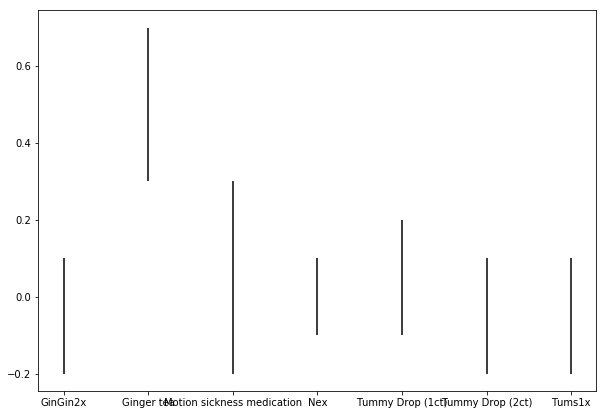

In [252]:
_ = pdf.plot_relative_effectiveness(pdf.relative_effectiveness)

In [270]:
list(map(str, dates))

['2018-01-01 00:00:00',
 '2018-01-01 01:00:00',
 '2018-01-01 02:00:00',
 '2018-01-01 03:00:00',
 '2018-01-01 04:00:00',
 '2018-01-01 05:00:00',
 '2018-01-01 06:00:00',
 '2018-01-01 07:00:00',
 '2018-01-01 08:00:00',
 '2018-01-01 09:00:00',
 '2018-01-01 10:00:00',
 '2018-01-01 11:00:00',
 '2018-01-01 12:00:00',
 '2018-01-01 13:00:00',
 '2018-01-01 14:00:00',
 '2018-01-01 15:00:00',
 '2018-01-01 16:00:00',
 '2018-01-01 17:00:00',
 '2018-01-01 18:00:00',
 '2018-01-01 19:00:00',
 '2018-01-01 20:00:00',
 '2018-01-01 21:00:00',
 '2018-01-01 22:00:00',
 '2018-01-01 23:00:00',
 '2018-01-02 00:00:00',
 '2018-01-02 01:00:00',
 '2018-01-02 02:00:00',
 '2018-01-02 03:00:00',
 '2018-01-02 04:00:00',
 '2018-01-02 05:00:00',
 '2018-01-02 06:00:00',
 '2018-01-02 07:00:00',
 '2018-01-02 08:00:00',
 '2018-01-02 09:00:00',
 '2018-01-02 10:00:00',
 '2018-01-02 11:00:00',
 '2018-01-02 12:00:00',
 '2018-01-02 13:00:00',
 '2018-01-02 14:00:00',
 '2018-01-02 15:00:00',
 '2018-01-02 16:00:00',
 '2018-01-02 17:

In [268]:
np.random.seed(42)
dates = pd.date_range(start='2018.01.01', end='2018.01.03', freq='1h')

temp = pd.DataFrame({
    'date_column': dates, #['2018.01.01 00:00:00', '2018.01.02 00:00:00', '2018.01.03 00:00:00'],
    "How does your stomach feel?": np.random.choice(['Noticeable', 'Totally fine', 'Distracting'], size=len(dates)),
    "Choose intervention": np.random.choice(['A', 'B', np.nan], p=[.1, .1, .8], size=len(dates)),
})
print(temp.shape)
temp

(49, 3)


date_column How does your stomach feel? Choose intervention
0  2018-01-01 00:00:00                 Distracting                 nan
1  2018-01-01 01:00:00                  Noticeable                 nan
2  2018-01-01 02:00:00                 Distracting                   A
3  2018-01-01 03:00:00                 Distracting                 nan
4  2018-01-01 04:00:00                  Noticeable                 nan
5  2018-01-01 05:00:00                  Noticeable                   B
6  2018-01-01 06:00:00                 Distracting                 nan
7  2018-01-01 07:00:00                Totally fine                   A
8  2018-01-01 08:00:00                 Distracting                 nan
9  2018-01-01 09:00:00                 Distracting                 nan
10 2018-01-01 10:00:00                 Distracting                 nan
11 2018-01-01 11:00:00                 Distracting                 nan
12 2018-01-01 12:00:00                  Noticeable                 nan
13 2018-01-01 13:00:00                 Distracting                 nan
14 2018-01-01 14:00:00                Totally fine                   B
15 2018-01-01 15:00:00                  Noticeable                 nan
16 2018-01-01 16:00:00                Totally fine                 nan
17 2018-01-01 17:00:00                Totally fine                 nan
18 2018-01-01 18:00:00                Totally fine                 nan
19 2018-01-01 19:00:00                Totally fine                 nan
20 2018-01-01 20:00:00                  Noticeable                 nan
21 2018-01-01 21:00:00                  Noticeable                   A
22 2018-01-01 22:00:00                Totally fine                   B
23 2018-01-01 23:00:00                Totally fine                   A
24 2018-01-02 00:00:00                  Noticeable                 nan
25 2018-01-02 01:00:00                  Noticeable                 nan
26 2018-01-02 02:00:00                  Noticeable                 nan
27 2018-01-02 03:00:00                 Distracting                 nan
28 2018-01-02 04:00:00                 Distracting                 nan
29 2018-01-02 05:00:00                 Distracting                 nan
30 2018-01-02 06:00:00                Totally fine                 nan
31 2018-01-02 07:00:00                 Distracting                   B
32 2018-01-02 08:00:00                Totally fine                 nan
33 2018-01-02 09:00:00                Totally fine                   A
34 2018-01-02 10:00:00                 Distracting                 nan
35 2018-01-02 11:00:00                Totally fine                 nan
36 2018-01-02 12:00:00                 Distracting                   B
37 2018-01-02 13:00:00                 Distracting                   A
38 2018-01-02 14:00:00                  Noticeable                 nan
39 2018-01-02 15:00:00                 Distracting                 nan
40 2018-01-02 16:00:00                  Noticeable                 nan
41 2018-01-02 17:00:00                 Distracting                 nan
42 2018-01-02 18:00:00                 Distracting                   A
43 2018-01-02 19:00:00                  Noticeable                 nan
44 2018-01-02 20:00:00                  Noticeable                   B
45 2018-01-02 21:00:00                 Distracting                 nan
46 2018-01-02 22:00:00                Totally fine                 nan
47 2018-01-02 23:00:00                  Noticeable                 nan
48 2018-01-03 00:00:00                Totally fine                   A

In [253]:
ls

bin/                   lib/                             quantifiedself.org
calories_20180729.png  literature_review_km.org         README.md
data/                  Nex_20180729.png                 reporter20180715.csv
etc/                   pip-selfcheck.json               results/
fat_20180729.png       prepost_analysis_20180720.ipynb  sandbox.ipynb
include/               prepost_analysis_20180729.ipynb  share/
jupyter_output.txt     preposterous/                    temp.png


In [242]:
%debug

> /home/mritter/.local/share/virtualenvs/preposterous-9I4DbeKd/lib/python3.6/site-packages/pandas/core/indexing.py(220)_has_valid_tuple()
    218         for i, k in enumerate(key):
    219             if i >= self.obj.ndim:
--> 220                 raise IndexingError('Too many indexers')
    221             try:
    222                 self._validate_key(k, i)

ipdb> u
> /home/mritter/.local/share/virtualenvs/preposterous-9I4DbeKd/lib/python3.6/site-packages/pandas/core/indexing.py(875)_getitem_tuple()
    873 
    874         # no multi-index, so validate all of the indexers
--> 875         self._has_valid_tuple(tup)
    876 
    877         # ugly hack for GH #836

ipdb> u
> /home/mritter/.local/share/virtualenvs/preposterous-9I4DbeKd/lib/python3.6/site-packages/pandas/core/indexing.py(1472)__getitem__()
   1470             except (KeyError, IndexError):
   1471                 pass
-> 1472             return self._getitem_tuple(key)
   1473         else:
   1474             # we by

In [224]:
multi_intervention_ix = pdf.df.intervention.fillna('')[lambda x: x.str.contains(',')].index
mono_intervention_ix = pdf.df.index.difference(multi_intervention_ix)
mono_intervention_ix

DatetimeIndex(['2018-07-04 20:22:00', '2018-07-04 20:22:39',
               '2018-07-04 20:23:14', '2018-07-04 20:23:35',
               '2018-07-04 20:33:38', '2018-07-04 20:43:20',
               '2018-07-04 21:26:52', '2018-07-04 22:18:02',
               '2018-07-04 22:43:48', '2018-07-05 00:44:01',
               ...
               '2018-07-28 12:55:24', '2018-07-28 14:30:41',
               '2018-07-28 17:35:36', '2018-07-28 23:29:06',
               '2018-07-29 00:43:45', '2018-07-29 02:04:42',
               '2018-07-29 11:59:51', '2018-07-29 12:51:12',
               '2018-07-29 14:55:37', '2018-07-29 16:48:13'],
              dtype='datetime64[ns]', length=258, freq=None)

In [204]:
%debug

> /home/mritter/.local/share/virtualenvs/preposterous-9I4DbeKd/lib/python3.6/site-packages/pandas/core/generic.py(4376)__getattr__()
   4374             if self._info_axis._can_hold_identifiers_and_holds_name(name):
   4375                 return self[name]
-> 4376             return object.__getattribute__(self, name)
   4377 
   4378     def __setattr__(self, name, value):

ipdb> u
> /home/mritter/code/preposterous/preposterous/preposterous.py(100)import_reporter()
     98             for intervention in row.intervention.split(','):
     99                 reporter_rows.append(pd.Series(
--> 100                     {'day': row.day,
    101                      'intervention': intervention,
    102                      'outcome': row.outcome,

ipdb> u
> /home/mritter/code/preposterous/preposterous/preposterous.py(80)read_csv()
     78         df.columns = df.columns.str.strip()
     79         if 'Choose intervention' in df.columns:
---> 80             return self.import_reporter(df)


ipdb> q


In [9]:
import preposterous.preposterous as ppl
pdf = ppl.PrePostDF()
pdf.add_outcome(filename='data/reporter20180729')
pdf.add_intervention(filename='data/reporter20180729')

In [10]:
pdf.basic_info()

Earliest recording: 2018.07.04
Latest recording: 2018.07.29
Recordings per day: 20.1
                    intervention outcome
2018-07-29 02:04:42          NaN     NaN
2018-07-29 11:59:51          NaN     NaN
2018-07-29 12:51:12          NaN     NaN
2018-07-29 14:55:37          NaN     NaN
2018-07-29 16:48:13          NaN     NaN


In [111]:
pdf.df.intervention.value_counts()

Tummy Drop (1ct)                       15
GinGin2x                               13
Ginger tea                             12
Nex                                    12
Tums1x                                  9
Tummy Drop (2ct)                        7
Motion sickness medication              5
Tums2x                                  3
Exercise                                3
Milk 1c                                 3
GinGin2x,Nex                            1
Tums1x,Nex                              1
Motion sickness medication,Exercise     1
Name: intervention, dtype: int64

In [110]:
pdf.df.outcome.value_counts()

Noticeable      148
                 52
Totally fine     36
Distracting      25
Name: outcome, dtype: int64

In [113]:
pdf.generate_confusion_matrix(intervention='Tummy Drop (1ct)')

sample size: 9
p-value of no effect: 1.00


Noticeable  Totally fine     ratio
post         7.0           2.0  0.222222
pre          8.0           1.0  0.111111

In [11]:
pdf.df.tail()

intervention outcome
2018-07-29 02:04:42          NaN     NaN
2018-07-29 11:59:51          NaN     NaN
2018-07-29 12:51:12          NaN     NaN
2018-07-29 14:55:37          NaN     NaN
2018-07-29 16:48:13          NaN     NaN

In [46]:
# 2h after each intervention on list

# for intervention in pdf.df.intervention.value_counts()[lambda x: x>5].index:
#     print(intervention)
intervention = 'Nex'
dts = pdf.df[pdf.df.intervention == 'Nex']
start = dts.index[0] + pd.Timedelta(1, 's')
end = start + pd.Timedelta(20, 'h') #TESTING
raw_outcomes = pdf.df.sort_index().loc[start:end, :]
# outcomes = raw_outcomes[(raw_outcomes.intervention.notnull().any())]
(raw_outcomes.intervention.notnull().any()) # Throw out if any other interventions
(raw_outcomes.outcome.notnull().sum() == 0) # Throw out if there are no outcomes
(raw_outcomes.outcome.nunique() > 0) # Throw out if there is mroe than one type of outcome
one_outcome = raw_outcomes.outcome.unique()[0] # If it passes all of these, its one value counts
int(one_outcome in ['Totally fine']) # The thing which will actually be counted

0

In [67]:
raw_outcomes.outcome.dropna().nunique()

1

In [118]:
confusion_matrix = pd.DataFrame(
    index=pdf.df.intervention.value_counts()[lambda x: x>5].index,
    columns=['positive', 'negative', 'other_intervention', 'no_outcomes', 'multiple_outcomes']
)
confusion_matrix.loc[:,:] = 0

for intervention in confusion_matrix.index:
# if 1:
#     intervention = 'Tums1x'
    for dt in pdf.df[pdf.df.intervention == intervention].index:
        start = dt + pd.Timedelta(1, 's')
        end = start + pd.Timedelta(2, 'h')
        raw_outcomes = pdf.df.sort_index().loc[start:end, :].replace('', np.nan)
        if raw_outcomes[raw_outcomes.intervention.notnull()].index.max() < raw_outcomes.index.max():
            confusion_matrix.loc[intervention, 'other_intervention'] += 1 # Throw out if any other interventions besides AT the final timestamp 
        elif raw_outcomes.outcome.notnull().sum() < 1:
            confusion_matrix.loc[intervention, 'no_outcomes'] += 1 # Throw out if there are no outcomes
        elif raw_outcomes.outcome.dropna().nunique() > 1:
            confusion_matrix.loc[intervention, 'multiple_outcomes'] += 1 # Throw out if there is more than one type of outcome
        elif raw_outcomes.outcome.dropna().unique()[0] in ['Noticeable', 'Distracting']:
            confusion_matrix.loc[intervention, 'negative'] += 1
        elif raw_outcomes.outcome.dropna().unique()[0] in ['Totally fine']:
            confusion_matrix.loc[intervention, 'positive'] += 1
        else:
            print(raw_outcomes)
            raise ValueError("Unexpected outcome")

confusion_matrix

positive  negative  other_intervention  no_outcomes  \
Tummy Drop (1ct)         1         6                   1            6   
GinGin2x                 1         8                   0            3   
Ginger tea               3         1                   1            7   
Nex                      1         6                   1            4   
Tums1x                   0         5                   1            3   
Tummy Drop (2ct)         0         4                   0            3   

                  multiple_outcomes  
Tummy Drop (1ct)                  1  
GinGin2x                          1  
Ginger tea                        0  
Nex                               0  
Tums1x                            0  
Tummy Drop (2ct)                  0

In [119]:
# Walk through and calc simple pct
for intervention in confusion_matrix.index:
#     confusion_matrix.loc[intervention, 'pct'] = confusion_matrix.loc[intervention, 'positive'] / confusion_matrix.loc[intervention, ['positive', 'negative']].sum()
    confusion_matrix.loc[intervention, 'n'] = confusion_matrix.loc[intervention, ['positive', 'negative']].sum()
    confusion_matrix.loc[intervention, 'positive_other'] = confusion_matrix.loc[confusion_matrix.index != intervention, ['positive']].sum().sum()
    confusion_matrix.loc[intervention, 'n_other'] = confusion_matrix.loc[confusion_matrix.index != intervention, ['positive', 'negative']].sum().sum()
    
confusion_matrix

positive  negative  other_intervention  no_outcomes  \
Tummy Drop (1ct)         1         6                   1            6   
GinGin2x                 1         8                   0            3   
Ginger tea               3         1                   1            7   
Nex                      1         6                   1            4   
Tums1x                   0         5                   1            3   
Tummy Drop (2ct)         0         4                   0            3   

                  multiple_outcomes    n  positive_other  n_other  
Tummy Drop (1ct)                  1  7.0             5.0     29.0  
GinGin2x                          1  9.0             5.0     27.0  
Ginger tea                        0  4.0             3.0     32.0  
Nex                               0  7.0             5.0     29.0  
Tums1x                            0  5.0             6.0     31.0  
Tummy Drop (2ct)                  0  4.0             6.0     32.0

In [125]:
# def bayesian_half(prepost_intervention, target='Totally fine'):
temp = pd.DataFrame(index=np.arange(0, 1, .1), columns=confusion_matrix.index)

original_columns = temp.columns
for intervention in original_columns:
    for p in temp.index:
        temp.loc[p, intervention] = scipy.stats.binom_test(
            x=confusion_matrix.loc[intervention, 'positive'],
            n=confusion_matrix.loc[intervention, 'n'], 
            p=p)
        
temp = temp.div(temp.sum())

# print("Probability that {} effective half the time: {:0.6f}".format(
#     intervention,
#     temp.loc[temp.index > .5, intervention].sum()))
# bayesian_half(prepost_intervention)
temp

Tummy Drop (1ct)     GinGin2x   Ginger tea          Nex       Tums1x  \
0.0                0            0            0            0     0.316271   
0.1          0.20012     0.410896  0.000842383      0.20012     0.316271   
0.2          0.38359     0.410896   0.00619266      0.38359     0.186726   
0.3         0.261742     0.121137    0.0190561     0.261742     0.104733   
0.4         0.097772    0.0392729    0.0703049     0.097772    0.0521214   
0.5        0.0479488    0.0160506     0.142294    0.0479488    0.0197669   
0.6       0.00722746   0.00156185     0.227671   0.00722746   0.00323861   
0.7       0.00145411  0.000177929     0.227671   0.00145411  0.000768537   
0.8      0.000142389  7.78401e-06     0.227671  0.000142389  0.000101207   
0.9      2.45498e-06  3.36935e-08    0.0782961  2.45498e-06  3.16271e-06   

    Tummy Drop (2ct)  
0.0         0.274771  
0.1         0.274771  
0.2         0.274771  
0.3        0.0889707  
0.4        0.0426444  
0.5        0.0343463  
0.6       0.00703413  
0.7       0.00222564  
0.8      0.000439633  
0.9      2.74771e-05

In [132]:
temp2 = pd.DataFrame(index=np.arange(0, 1, .1), columns=confusion_matrix.index)

for intervention in temp2.columns:
    for p in temp2.index:
        temp2.loc[p, intervention] = scipy.stats.binom_test(
            x=confusion_matrix.loc[intervention, 'positive_other'],
            n=confusion_matrix.loc[intervention, 'n_other'], 
            p=p)

temp2 = temp2.div(temp2.sum())
temp2

Tummy Drop (1ct)     GinGin2x   Ginger tea          Nex       Tums1x  \
0.0                0            0            0            0            0   
0.1         0.149237     0.129101     0.837627     0.149237    0.0874574   
0.2         0.726052     0.698951     0.153223     0.726052     0.719384   
0.3         0.115009     0.150697   0.00898084     0.115009     0.173782   
0.4       0.00930436    0.0201832  0.000166557   0.00930436    0.0187401   
0.5      0.000396506   0.00105802  2.14099e-06  0.000396506  0.000631555   
0.6      2.43415e-06  9.68776e-06  2.76659e-09  2.43415e-06  5.33613e-06   
0.7      4.46787e-09  3.27417e-08   1.0211e-12  4.46787e-09  5.84616e-09   
0.8       4.9865e-13  8.19474e-12  1.17103e-17   4.9865e-13   4.9407e-13   
0.9      5.20644e-20  3.41391e-18  3.06262e-26  5.20644e-20  2.88856e-20   

    Tummy Drop (2ct)  
0.0                0  
0.1        0.0968431  
0.2         0.752264  
0.3         0.137282  
0.4        0.0132054  
0.5      0.000402501  
0.6      3.00943e-06  
0.7      2.24852e-09  
0.8      1.26896e-13  
0.9      3.71406e-21

In [142]:
l = []
for intervention in temp2.columns:
    for i1 in temp.index:
        for i2 in temp2.index:
            l.append([intervention, round(i1 - i2, 1), temp.loc[i1, intervention] * temp2.loc[i2, intervention]])
l[:5]

[['Tummy Drop (1ct)', 0.0, 0.0],
 ['Tummy Drop (1ct)', -0.1, 0.0],
 ['Tummy Drop (1ct)', -0.2, 0.0],
 ['Tummy Drop (1ct)', -0.3, 0.0],
 ['Tummy Drop (1ct)', -0.4, 0.0]]

In [145]:
temp3 = pd.DataFrame(l, columns=['intervention', 'delta', 'prob']).groupby(['intervention', 'delta']).sum().unstack(0).round(2)
temp3#.sum()

prob                                                     \
intervention GinGin2x Ginger tea   Nex Tummy Drop (1ct) Tummy Drop (2ct)   
delta                                                                      
-0.9             0.00       0.00  0.00             0.00             0.00   
-0.8             0.00       0.00  0.00             0.00             0.00   
-0.7             0.00       0.00  0.00             0.00             0.00   
-0.6             0.00       0.00  0.00             0.00             0.00   
-0.5             0.00       0.00  0.00             0.00             0.00   
-0.4             0.00       0.00  0.00             0.00             0.00   
-0.3             0.01       0.00  0.00             0.00             0.04   
-0.2             0.07       0.00  0.03             0.03             0.25   
-0.1             0.35       0.00  0.19             0.19             0.27   
 0.0             0.36       0.00  0.34             0.34             0.25   
 0.1             0.14       0.01  0.26             0.26             0.10   
 0.2             0.05       0.03  0.12             0.12             0.05   
 0.3             0.02       0.08  0.05             0.05             0.03   
 0.4             0.00       0.16  0.01             0.01             0.01   
 0.5             0.00       0.23  0.00             0.00             0.00   
 0.6             0.00       0.23  0.00             0.00             0.00   
 0.7             0.00       0.20  0.00             0.00             0.00   
 0.8             0.00       0.07  0.00             0.00             0.00   
 0.9             0.00       0.00  0.00             0.00             0.00   

                     
intervention Tums1x  
delta                
-0.9           0.00  
-0.8           0.00  
-0.7           0.00  
-0.6           0.00  
-0.5           0.00  
-0.4           0.01  
-0.3           0.06  
-0.2           0.29  
-0.1           0.29  
 0.0           0.18  
 0.1           0.10  
 0.2           0.05  
 0.3           0.02  
 0.4           0.00  
 0.5           0.00  
 0.6           0.00  
 0.7           0.00  
 0.8           0.00  
 0.9           0.00

In [156]:
temp3.cumsum()

prob                                                     \
intervention GinGin2x Ginger tea   Nex Tummy Drop (1ct) Tummy Drop (2ct)   
delta                                                                      
-0.9             0.00       0.00  0.00             0.00             0.00   
-0.8             0.00       0.00  0.00             0.00             0.00   
-0.7             0.00       0.00  0.00             0.00             0.00   
-0.6             0.00       0.00  0.00             0.00             0.00   
-0.5             0.00       0.00  0.00             0.00             0.00   
-0.4             0.00       0.00  0.00             0.00             0.00   
-0.3             0.01       0.00  0.00             0.00             0.04   
-0.2             0.08       0.00  0.03             0.03             0.29   
-0.1             0.43       0.00  0.22             0.22             0.56   
 0.0             0.79       0.00  0.56             0.56             0.81   
 0.1             0.93       0.01  0.82             0.82             0.91   
 0.2             0.98       0.04  0.94             0.94             0.96   
 0.3             1.00       0.12  0.99             0.99             0.99   
 0.4             1.00       0.28  1.00             1.00             1.00   
 0.5             1.00       0.51  1.00             1.00             1.00   
 0.6             1.00       0.74  1.00             1.00             1.00   
 0.7             1.00       0.94  1.00             1.00             1.00   
 0.8             1.00       1.01  1.00             1.00             1.00   
 0.9             1.00       1.01  1.00             1.00             1.00   

                     
intervention Tums1x  
delta                
-0.9           0.00  
-0.8           0.00  
-0.7           0.00  
-0.6           0.00  
-0.5           0.00  
-0.4           0.01  
-0.3           0.07  
-0.2           0.36  
-0.1           0.65  
 0.0           0.83  
 0.1           0.93  
 0.2           0.98  
 0.3           1.00  
 0.4           1.00  
 0.5           1.00  
 0.6           1.00  
 0.7           1.00  
 0.8           1.00  
 0.9           1.00

In [168]:
temp3.loc[:, ('prob', 'Nex')].cumsum()[lambda x: x < .95].index.max()
temp3.loc[:, ('prob', 'Nex')].cumsum()[lambda x: x > .05].index.min()

-0.1

In [200]:
! pip freeze | grep matplotlib

matplotlib==2.2.2


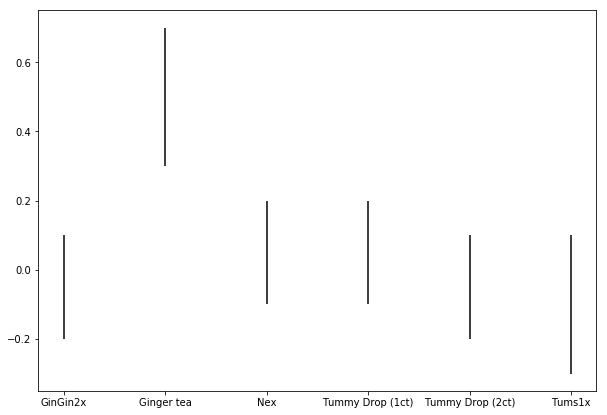

In [173]:
fig, ax = plt.subplots(1, 1, figsize=(10, 7))

for intervention in temp3.prob.columns:
    ax.vlines(
        x=intervention, 
        ymin=temp3.loc[:, ('prob', intervention)].cumsum()[lambda x: x > .05].index.min(),
        ymax=temp3.loc[:, ('prob', intervention)].cumsum()[lambda x: x < .95].index.max()
    )

# ax.vlines(x=.3, ymin=.3, ymax=.7)